In [1]:
import numpy as np

def legendre_P(l, m, x):
    """
    Associated Legendre Polynomial P_lm(x).
    """
    if m == 0:
        return np.polynomial.legendre.Legendre.basis(l)(x)
    elif m>l:
        return 0
    elif m > 0:
        pmm = np.sqrt(1.0 - x**2)**m
        pmm = pmm * np.polynomial.legendre.Legendre.basis(l-m)(x)
        den = 1.0
        for i in range(1, m+1):
            pmm = pmm * (1.0 - x**2)**0.25 / np.sqrt(den)
            den += 2.0
        return pmm
    else:
        m = abs(m)
        pmmp1 = x * (2.0*m-1.0) * legendre_P(l, m-1, x)
        if l == m:
            return pmmp1
        else:
            pmm = (x * (2.0*l-1.0) * legendre_P(l-1, m, x) - (l+m-1.0) * legendre_P(l-2, m, x)) / (l-m)
            return pmm
        

def legP(l, m, x):
    """
    Associated Legendre Polynomial P_lm(x).
    """
    basisnan = lambda x: 0
    basis0 = lambda x: 1
    basis1 = lambda x: x
    if m>l or m<-l:
        return basisnan(x)
    if l==0:
        return basis0(x)
    if l==1:
        return basis1(x)
    if l-m==0:
        # return (-1)**l*np.math.factorial(np.math.factorial(2*l-1))*np.sqrt(1-x**2)
        return  np.polynomial.legendre.Legendre.basis(l)(x)
    else:
        return ((2*l-1)*x/(l-m)*legP(l-1,m,x) - (l+m-1)/(l-m)*legP(l-2,m,x))/(m+1)
    
def factorial(n):
    """
    Factorial function.
    """
    return 1 if n == 0 else n * factorial(n - 1)

def normalization_constant(l, m):
    """
    Normalization constant for spherical harmonics.
    """
    return np.sqrt((2 * l + 1) * factorial(l - m) / (4 * np.pi * factorial(l + m)))

def spherical_harmonic(l, m, theta, phi):
    """
    Compute spherical harmonic Y_lm(theta, phi) at given theta and phi.
    """
    if m < 0:
        return np.sqrt(2) * normalization_constant(l, m) * legendre_P(l, abs(m), np.cos(theta)) * np.sin(abs(m) * phi)
    elif m > 0:
        return np.sqrt(2) * normalization_constant(l, m) * legendre_P(l, m, np.cos(theta)) * np.cos(m * phi)
    else:
        return normalization_constant(l, m) * legendre_P(l, 0, np.cos(theta))

def spherical_harmonic_transform(theta, phi, grid):
    """
    Compute the spherical harmonic transform of the grid data.
    """
    lmax = grid.shape[0] - 1
    mmax = lmax
    coeffs = np.zeros((lmax + 1, mmax + 1), dtype=complex)

    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            coeff_sum = 0.0
            for i in range(len(theta)):
                coeff_sum += grid[i] * np.conj(spherical_harmonic(l, m, theta[i], phi[i]))
            coeffs[l, m] = coeff_sum / len(theta)

    return coeffs


## TODO put in weight for car grid..
def forward_spherical_harmonic_transform(theta, phi, grid_data, lmax):
    """
    Compute the forward spherical harmonic transform to obtain coefficients.
    """
    Nlat, Nlon = len(theta), len(phi)
    coeffs = np.zeros((lmax + 1, lmax + 1), dtype=complex)
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            coeff_sum = 0.0
            for i in range(Nlat):
                for j in range(Nlon):
                    theta_val = theta[i, j]
                    phi_val = phi[i, j]
                    coeff_sum += grid_data[i, j] * np.conj(spherical_harmonic(l, m, theta_val, phi_val))
            coeffs[l, m] = coeff_sum
    return coeffs

In [2]:
import matplotlib.pyplot as plt
x = np.arange(-1,1,0.001)
for l in range(5):
    for m in range(0):
        plt.plot(x, legendre_P(l,m,x))
        
plt.show()

/var/folders/y7/n0p9yyhs42b5mpthyfln9q340000gq/T/ipykernel_91390/2158231257.py:46: RuntimeWarning: divide by zero encountered in divide
  return ((2*l-1)*x/(l-m)*legP(l-1,m,x) - (l+m-1)/(l-m)*legP(l-2,m,x))/(m+1)
/var/folders/y7/n0p9yyhs42b5mpthyfln9q340000gq/T/ipykernel_91390/2158231257.py:46: RuntimeWarning: invalid value encountered in subtract
  return ((2*l-1)*x/(l-m)*legP(l-1,m,x) - (l+m-1)/(l-m)*legP(l-2,m,x))/(m+1)


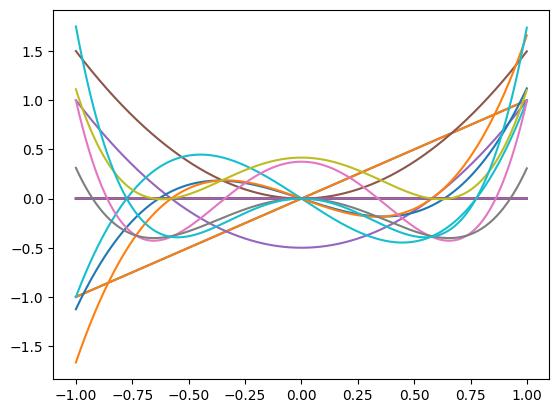

In [3]:
import matplotlib.pyplot as plt
x = np.arange(-1,1,0.001)
for l in range(5):
    for m in range(-l,l):
        plt.plot(x, legP(l,m,x))

In [3]:
nlat = 1000
nlon = 1000
theta = np.linspace(0, np.pi, nlat)
phi = np.linspace(0, 2 * np.pi, nlon)
phi, theta = np.meshgrid(phi, theta)

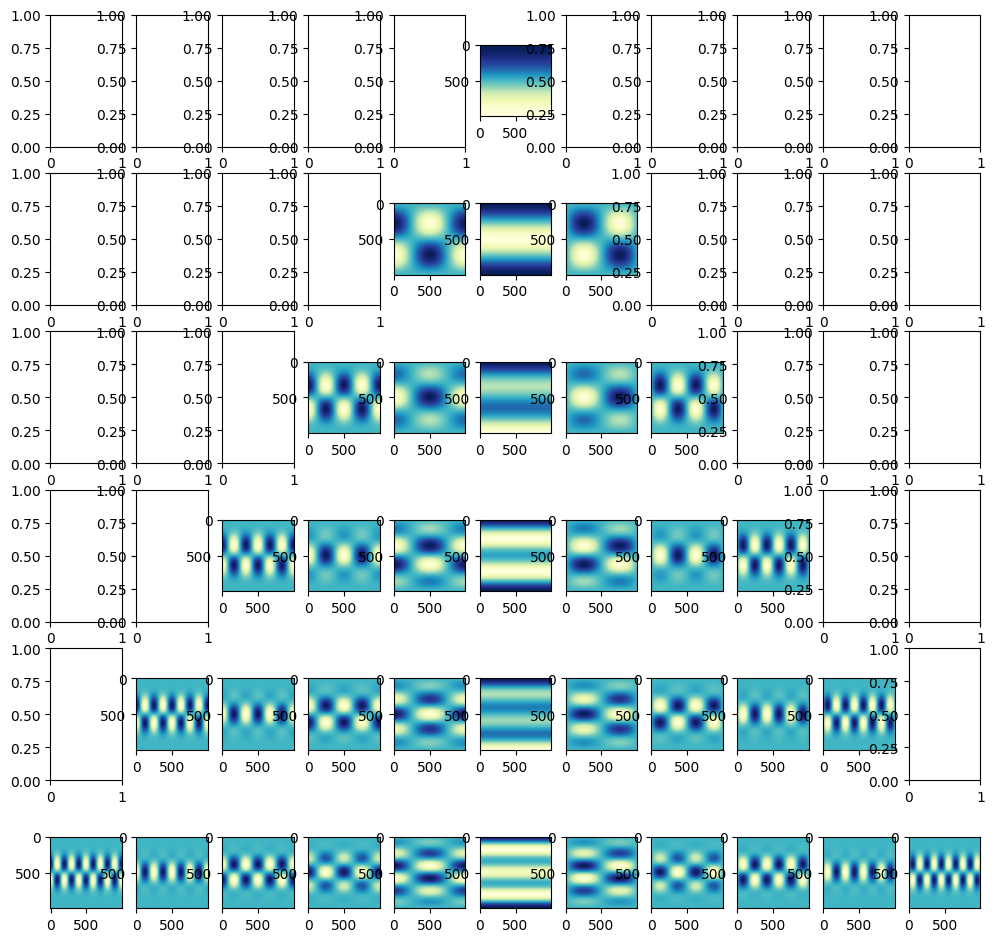

In [5]:
l = 6
f, axarr = plt.subplots(l,2*l-1,figsize=(12,12))
for l in range(0,6):
    for m in range(-l,l+1):
        axarr[l][5-m].imshow(spherical_harmonic(l+1,m,theta,phi), cmap='YlGnBu')
plt.show()

In [4]:
grid_data = 0
for l in range(2,3):
    for m in range(-l,l+1):
        print(l,m)
        grid_data += spherical_harmonic(l,m,theta,phi)

2 -2
2 -1
2 0
2 1
2 2


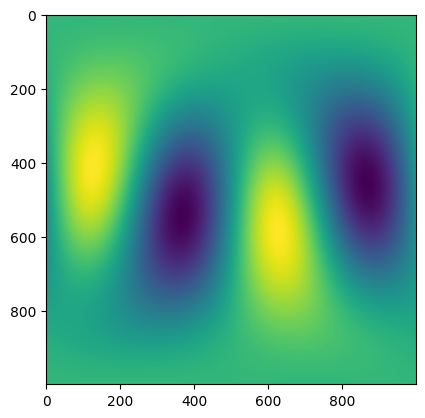

In [7]:
plt.imshow(grid_data)

In [8]:
Nlat, Nlon = 1000, 1000
theta = np.linspace(0, np.pi, Nlat)
phi = np.linspace(0, 2 * np.pi, Nlon)
phi, theta = np.meshgrid(phi, theta)

# Compute the inverse spherical harmonic transform
lmax = 3
coeffs = forward_spherical_harmonic_transform(theta, phi, grid_data, lmax)


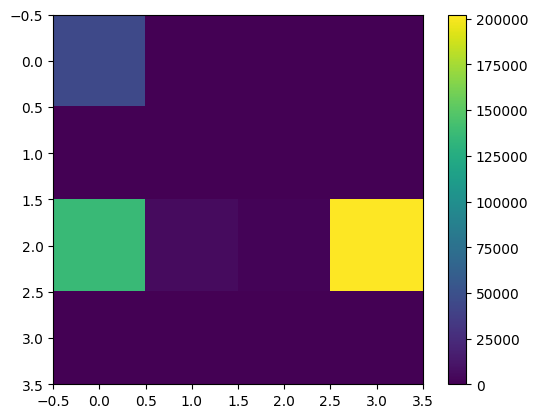

In [9]:
plt.imshow(np.abs(coeffs))
plt.colorbar()

In [5]:
# Example usage:
# Generate sample data on a grid
nlat, nlon = 100, 200
theta = np.linspace(0, np.pi, nlat)
phi = np.linspace(0, 2 * np.pi, nlon)
phi, theta = np.meshgrid(phi, theta)

# Sample grid data (just a simple example)
grid_data = np.sin(theta) * np.cos(phi)

# Compute the spherical harmonic transform
coeffs = spherical_harmonic_transform(theta.ravel(), phi.ravel(), grid_data.ravel())

print("Spherical harmonic coefficients shape:", coeffs.shape)